# Bert-base-multilingual-uncased

In [1]:
#!pip install ktrain

In [2]:
#!pip install sentence_transformers

First we import the necessary libraries and load the csv

In [3]:
import pandas as pd
import numpy as np
import tensorflow as tf
import ktrain
from ktrain import text

c:\Users\volpe\anaconda3\envs\kt\lib\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


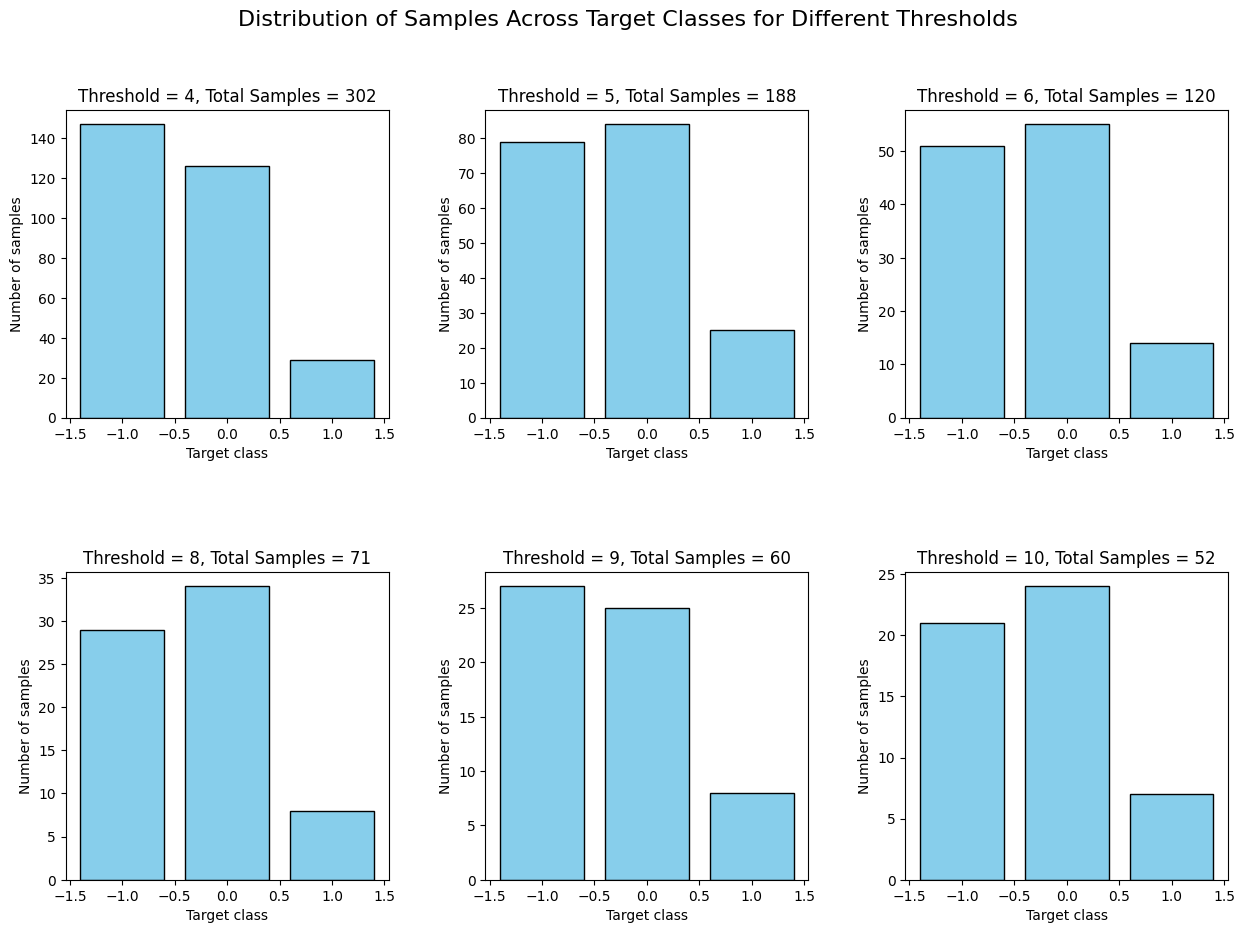

In [8]:
import matplotlib.pyplot as plt
import pandas as pd

threshold = [4,5, 6, 8, 9, 10]
file_list_1 = ["data_2805(puntoevirgola).csv", "data_2905(puntoevirgola).csv"]
file_list_2 = ["data_0905_semicolon.csv","data_2705_semicolon.csv","data_2805(puntoevirgola).csv", "data_2905(puntoevirgola).csv"]
target = [-1, 0, 1]
col = ["Ticker"] + ["Article " + str(i + 1) for i in range(10)] + ["Target"] + ["Concatenated Titles"]

# Create subplots
fig, axes = plt.subplots(nrows=2, ncols=3, figsize=(15, 10))
fig.subplots_adjust(hspace=0.5, wspace=0.3)  # Adjust spacing between subplots

for i, T in enumerate(threshold):
    row_index = i // 3
    col_index = i % 3

    all_data_set = pd.DataFrame(columns=col)  # Initialize DataFrame for each threshold

    for file_name in file_list_1:
        data_set = pd.read_csv(file_name, sep=";")
        input_df = pd.DataFrame(columns=col)

        for ticker in data_set["Ticker"].unique():
            ticker_df = data_set[data_set["Ticker"] == ticker]
            articles_list = ticker_df["Titles"].to_list()

            if len(articles_list) >= T:
                articles_list = articles_list[:T]
                ticker_target = ticker_df["Target"].iloc[0]
                new_row = [ticker] + articles_list + [""] * (10 - T) + [ticker_target] + [" ".join(articles_list)]
                input_df.loc[len(input_df.index)] = new_row
        all_data_set = pd.concat([all_data_set, input_df], ignore_index=True)

    # Plot the distribution of samples for the current threshold
    ax = axes[row_index, col_index]
    ax.bar(target, [all_data_set[all_data_set["Target"] == t].shape[0] for t in target], color='skyblue',
           edgecolor='black')
    ax.set_xlabel('Target class')
    ax.set_ylabel('Number of samples')
    ax.set_title('Threshold = ' + str(T) + ", Total Samples = " + str(all_data_set.shape[0]))

# Add a common title for all subplots
fig.suptitle('Distribution of Samples Across Target Classes for Different Thresholds', fontsize=16)

plt.show()


We choose T = 5, the dataset is strongly unbalanced

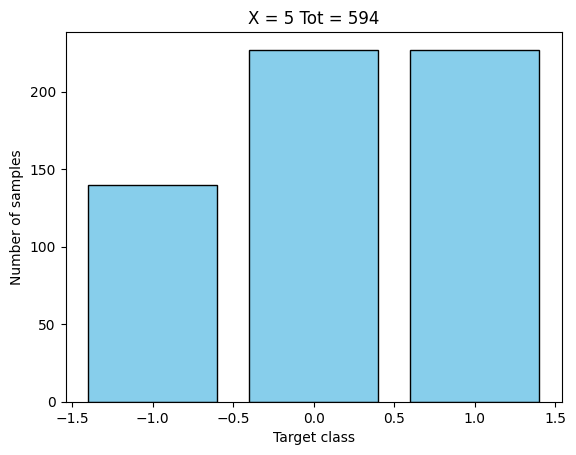

[140, 227, 227]


In [6]:
all_data_set = pd.DataFrame(columns=col)  # Initialize DataFrame for each threshold
for file_name in file_list_2:
    data_set = pd.read_csv(file_name, sep=";")
    input_df = pd.DataFrame(columns=col)
    for ticker in data_set["Ticker"].unique():
        ticker_df = data_set[data_set["Ticker"] == ticker]
        articles_list = ticker_df["Titles"].to_list()
        if len(articles_list) >= T:
            articles_list = articles_list[:T]
            ticker_target = ticker_df["Target"].iloc[0]
            new_row = [ticker] + articles_list + [""] * (10 - T) + [ticker_target] + [" ".join(articles_list)]
            input_df.loc[len(input_df.index)] = new_row
    all_data_set = pd.concat([all_data_set, input_df], ignore_index=True)
# Cleaning the columns
for i in range(1, 11):
    column_name = f'Article {i}'
    all_data_set[column_name] = all_data_set[column_name].str.replace('<title>', '').str.replace('</title>', '')
all_data_set["Concatenated Titles"] = all_data_set["Concatenated Titles"].str.replace('<title>', '').str.replace('</title>', '')

input_df = all_data_set
'''
# We rebalance the dataset
num_rows_to_keep = max(all_data_set[all_data_set["Target"] == 1].shape[0], all_data_set[all_data_set["Target"] == -1].shape[0])

subset_to_keep = all_data_set[all_data_set["Target"] == 0].sample(n = num_rows_to_keep)
input_df = pd.concat([subset_to_keep,all_data_set[all_data_set["Target"] == 1],all_data_set[all_data_set["Target"] == -1]])

plt.bar( target ,[input_df[input_df["Target"] == t ].shape[0] for t in target], color='skyblue', edgecolor='black')

plt.xlabel('Target class')
plt.ylabel('Number of samples')
plt.title('X = 5'+" Tot = " +str(input_df.shape[0]))

plt.show()
print([input_df[input_df["Target"] == t ].shape[0] for t in target])
'''

Now we divide the dataset in training set, validation set and test set

In [59]:
from sklearn.model_selection import train_test_split

X = input_df.filter(["Concatenated Titles"],axis=1)
Y = input_df.filter(["Target"],axis=1)
#print(Y)

x_train, x_Final_test, y_train, y_Final_test = train_test_split( X, Y, test_size=0.20, random_state=42)
x_train, x_test, y_train, y_test = train_test_split( x_train, y_train, test_size=0.20, random_state=42)

In [60]:
model_name = 'bert-base-multilingual-uncased'
transformer = text.Transformer(model_name, maxlen=500, class_names= np.array([0,1,2]))
y_train = y_train + 1          # classes need to start from
y_test = y_test + 1

In [9]:
processed_train = transformer.preprocess_train(list(x_train["Concatenated Titles"]), list(y_train["Target"]))
processed_test = transformer.preprocess_test(list(x_test["Concatenated Titles"]), list(y_test["Target"]))

preprocessing train...
language: en
train sequence lengths:
	mean : 137
	95percentile : 160
	99percentile : 174


c:\Users\volpe\anaconda3\envs\kt\lib\site-packages\ktrain\utils.py:769: UserWarning: class_names implies classification but targets array contains float(s) instead of integers or strings
  "class_names implies classification but targets array contains float(s) instead of integers or strings"


Is Multi-Label? False
preprocessing test...
language: en
test sequence lengths:
	mean : 137
	95percentile : 164
	99percentile : 169


In [10]:
model = transformer.get_classifier()
batch_size = 5                        #small training dataset
learner = ktrain.get_learner(model, train_data=processed_train, val_data=processed_test, batch_size=batch_size)

In [11]:
print(processed_train.y)

[[0. 1. 0.]
 [0. 0. 1.]
 [0. 1. 0.]
 ...
 [1. 0. 0.]
 [0. 1. 0.]
 [0. 1. 0.]]


simulating training for different learning rates... this may take a few moments...
79/79 [==============================] - 888s 11s/step - loss: 27.6450 - accuracy: 0.4632


done.
Visually inspect loss plot and select learning rate associated with falling loss


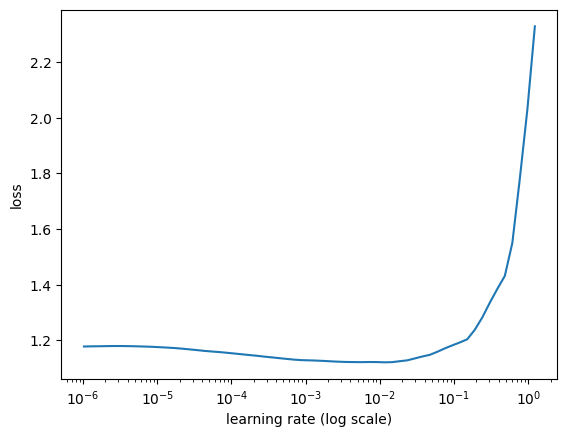

In [12]:
learner.lr_find(show_plot=True,  max_epochs=1)

In [13]:
learner.fit_onecycle(1e-3, 2)



begin training using onecycle policy with max lr of 0.001...
Epoch 1/2
80/80 [==============================] - 1035s 13s/step - loss: 0.9487 - accuracy: 0.6583 - val_loss: 1.5105 - val_accuracy: 0.5900
Epoch 2/2
80/80 [==============================] - 1058s 13s/step - loss: 0.9086 - accuracy: 0.6910 - val_loss: 0.9793 - val_accuracy: 0.5900


In [14]:
learner.validate(class_names=transformer.get_classes())

4/4 [==============================] - 40s 8s/step
              precision    recall  f1-score   support

           0       0.00      0.00      0.00        23
           1       0.59      1.00      0.74        59
           2       0.00      0.00      0.00        18

    accuracy                           0.59       100
   macro avg       0.20      0.33      0.25       100
weighted avg       0.35      0.59      0.44       100



c:\Users\volpe\anaconda3\envs\kt\lib\site-packages\sklearn\metrics\_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
c:\Users\volpe\anaconda3\envs\kt\lib\site-packages\sklearn\metrics\_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
c:\Users\volpe\anaconda3\envs\kt\lib\site-packages\sklearn\metrics\_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


array([[ 0, 23,  0],
       [ 0, 59,  0],
       [ 0, 18,  0]], dtype=int64)

In [15]:
'''
# let's see some predictions
'''
predictor = ktrain.get_predictor(learner.model, preproc=transformer)
import random as rand
i = rand.randint(0,100)

print(input_df["Ticker"].iloc[i],"\n",\
      "Prediction: \n",\
      predictor.predict(x_test["Concatenated Titles"].iloc[i]),\
      "\nTarget: \n",\
      y_train["Target"].iloc[i])

CCL 
 Prediction: 
 1 
Target: 
 0.0


It always predicts class 1... not really good

### Let's try embedding + NN

In [65]:
from sentence_transformers import SentenceTransformer

In [67]:
m = SentenceTransformer("google-bert/bert-base-multilingual-uncased")

No sentence-transformers model found with name C:\Users\volpe/.cache\torch\sentence_transformers\google-bert_bert-base-multilingual-uncased. Creating a new one with MEAN pooling.


In [69]:
c = len(m.encode("I love embeddings!"))                   # dim embedding
r = input_df.shape[0]    # dim dataset  

X = np.zeros((r,c))
for idx in range(r):
  sentence_embeddings = m.encode(input_df.iloc[idx,:].loc["Concatenated Titles"])
  X[idx,:] = sentence_embeddings

In [70]:
input_df.iloc[497,:].loc["Concatenated Titles"]

"Insider Selling: Freeport-McMoRan Inc. (NYSE:FCX) CEO Sells 54771 Shares of Stock - Defense World Freeport (FCX) to Report Q4 Earnings: What's in the Cards? - Yahoo Finance Freeport-McMoRan Inc (FCX) Reports Strong Q3 2023 Results with Net Income of $454 Million - Yahoo Finance Freeport-McMoRan (FCX) Outpaces Stock Market Gains: What You Should Know - Yahoo Finance Freeport-McMoran (FCX) Tops Q1 EPS by 3c - StreetInsider.com The Freeport-McMoRan Inc (FCX) Company: A Short SWOT Analysis - Yahoo Finance FCX Stock Forecast: Is Freeport-McMoRan a Good Cyclical Buy for 2024? - Barchart This Is What Whales Are Betting On Freeport-McMoRan - Freeport-McMoRan (NYSE:FCX) - Benzinga Why Freeport-McMoRan (FCX) Dipped More Than Broader Market Today - Yahoo Finance Is Trending Stock Freeport-McMoRan Inc. (FCX) a Buy Now? - Yahoo Finance"

In [71]:
t_size = 0.2

x_train, x_test, y_train, y_test = train_test_split( X, np.array(input_df["Target"]), test_size=t_size, random_state=42)

In [72]:
import numpy as np
import matplotlib.pyplot as plt
from keras.models import Sequential
from keras.layers import Dense
from keras.optimizers import Adam, RMSprop, SGD, Adagrad

We prepare the data for a classification with neural networks

In [73]:
#to train the NN we need to convert integer output to binary array
num_classes = 3

y_train_dummy = np.zeros((len(y_train), num_classes))
for i in range(0,len(y_train)):
    class_idx = round(y_train[i])  
    y_train_dummy[i, class_idx] = 1


y_test_dummy = np.zeros((len(y_test), num_classes))
for i in range(0,len(y_test)):
  y_test_dummy[i,round(y_test[i])] = 1

And train a neural network

In [74]:
model=Sequential()
model.add(Dense(units=900, activation='relu', input_dim=c))
model.add(Dense(units=200, activation='tanh'))
model.add(Dense(units=200, activation='relu'))
model.add(Dense(units=3, activation='sigmoid'))    #output layer
model.compile(loss='mse',
              optimizer=Adam(lr=0.0001,beta_1=0.9,beta_2=0.999))

model.fit(x_train,y_train,epochs=200,batch_size=6)  


pred_train=model.predict(x_train)
pred_test=model.predict(x_test)

Epoch 1/200


c:\Users\volpe\anaconda3\envs\kt\lib\site-packages\keras\optimizers\optimizer_v2\adam.py:117: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super().__init__(name, **kwargs)


80/80 [==============================] - 1s 4ms/step - loss: 0.6166
Epoch 2/200
80/80 [==============================] - 0s 4ms/step - loss: 0.6020
Epoch 3/200
80/80 [==============================] - 0s 4ms/step - loss: 0.6010
Epoch 4/200
80/80 [==============================] - 0s 4ms/step - loss: 0.5949
Epoch 5/200
80/80 [==============================] - 0s 4ms/step - loss: 0.5896
Epoch 6/200
80/80 [==============================] - 0s 4ms/step - loss: 0.5855
Epoch 7/200
80/80 [==============================] - 0s 4ms/step - loss: 0.5762
Epoch 8/200
80/80 [==============================] - 0s 4ms/step - loss: 0.5837
Epoch 9/200
80/80 [==============================] - 0s 5ms/step - loss: 0.5564
Epoch 10/200
80/80 [==============================] - 0s 5ms/step - loss: 0.5457
Epoch 11/200
80/80 [==============================] - 0s 6ms/step - loss: 0.5321
Epoch 12/200
80/80 [==============================] - 0s 6ms/step - loss: 0.6055
Epoch 13/200
80/80 [=============================

Now we evaluate the model on the validation set

In [75]:
pred_test_2 = np.zeros(pred_test.shape)
for i in range(len(pred_test)):
  pred_test_2[i, pred_test[i,:].argmax()  ] = 1

pred_train_2 = np.zeros(pred_train.shape)
for i in range(len(pred_train)):
  pred_train_2[i, pred_train[i,:].argmax()  ] = 1

In [76]:
#print(pred_train.shape,"--",x_train.shape)
#print(pred_test.shape,"--",x_test.shape)

print(pred_train[23,:],"--",y_train_dummy[0,:])
print(  )
print("Prediction","--","  Target")
for i in range(180,200):
  print(pred_train_2[i,:],"--",y_train_dummy[i,:])

[0.9999705  0.99996775 0.9999627 ] -- [1. 0. 0.]

Prediction --   Target
[0. 0. 1.] -- [1. 0. 0.]
[0. 1. 0.] -- [0. 1. 0.]
[0. 0. 1.] -- [1. 0. 0.]
[1. 0. 0.] -- [0. 1. 0.]
[0. 0. 1.] -- [0. 0. 1.]
[0. 0. 1.] -- [1. 0. 0.]
[0. 0. 1.] -- [1. 0. 0.]
[1. 0. 0.] -- [0. 1. 0.]
[0. 0. 1.] -- [0. 1. 0.]
[0. 0. 1.] -- [0. 0. 1.]
[1. 0. 0.] -- [0. 1. 0.]
[0. 1. 0.] -- [1. 0. 0.]
[0. 0. 1.] -- [0. 0. 1.]
[0. 0. 1.] -- [1. 0. 0.]
[0. 0. 1.] -- [0. 0. 1.]
[0. 0. 1.] -- [0. 0. 1.]
[0. 0. 1.] -- [1. 0. 0.]
[1. 0. 0.] -- [0. 1. 0.]
[1. 0. 0.] -- [0. 1. 0.]
[0. 0. 1.] -- [0. 0. 1.]


In [77]:
MSE_train = np.sum(  (pred_train-y_train_dummy)**2)   /pred_train.shape[0]
MSE_test = np.sum(  (pred_test-y_test_dummy)**2)   /pred_test.shape[0]

print("MSE_train: ",MSE_train)
print("MSE_test: ",MSE_test)


MSE_train = np.sum(  (pred_train_2-y_train_dummy)**2)   /pred_train.shape[0]
MSE_test = np.sum(  (pred_test_2-y_test_dummy)**2)   /pred_test.shape[0]

print("MSE_train: ",MSE_train)
print("MSE_test: ",MSE_test)

MSE_train:  1.3696593389095273
MSE_test:  1.1856933690671276
MSE_train:  1.3852631578947368
MSE_test:  1.3109243697478992


In [78]:
miss_train = np.sum(  abs(pred_train_2-y_train_dummy)/2)   /pred_train.shape[0]
miss_test = np.sum(  abs(pred_test_2-y_test_dummy)/2)   /pred_test.shape[0]

print("Missclasification_train: ",miss_train)
print("Missclassification_test: ",miss_test)

Missclasification_train:  0.6926315789473684
Missclassification_test:  0.6554621848739496
